# LIT

In [8]:
!pip install tensorflow==2.14.1 lit-nlp keras_nlp

INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow_text-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached tensorflow_text-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 42.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 55.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attemp

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Set `PATH` to include the directory containing saved_model_cli
PATH = %env PATH
%env PATH=/home/jupyter/.local/bin:{PATH}

env: PATH=/home/jupyter/.local/bin:/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games


In [2]:
import datetime
import shutil

import keras

# import tensorflow_hub as hub
import keras_nlp

# import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text as text

# from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel("ERROR")

2024-09-05 12:25:39.887567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 12:25:39.887614: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 12:25:39.887647: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


### Sentiment Analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

path = "/home/jupyter/"
dataset = keras.utils.get_file(
    "aclImdb_v1.tar.gz", url, untar=True, cache_dir=path, cache_subdir=""
)

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

train_dir = os.path.join(dataset_dir, "train")

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path + "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path + "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path + "aclImdb/test", batch_size=batch_size
)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


## Loading models from Keras NLP

<!-- For the purpose of this lab, we will be loading a model called Small BERT. Small BERT has the same general architecture as the original BERT but the has fewer and/or smaller Transformer blocks.

Some other popular BERT models are BERT Base, ALBERT, BERT Experts, Electra. See the continued learning section at the end of this lab for more info.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yeld even better accuracy but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub. -->

### Choose a BERT model to fine-tune

In [7]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased_sst2",
)

In [8]:
# lr_list = []
# for lr in range(num_train_steps):
#   lr_list.append(scheduler(lr))

# import matplotlib.pyplot as plt
# plt.plot(lr_list)

In [9]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

warmup_tgt = 3e-5
scheduler = tf.keras.optimizers.schedules.CosineDecay(
    0.0,
    num_train_steps,
    warmup_target=warmup_tgt,
    warmup_steps=num_warmup_steps,
)

optimizer = tf.keras.optimizers.AdamW(learning_rate=scheduler)

In [12]:
classifier.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.metrics.SparseCategoricalAccuracy()],
)

In [14]:
FILE_PATH = "./model"

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    FILE_PATH,
    monitor="val_loss",
    save_best_only=True,
)

history = classifier.fit(
    x=train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint_cb]
)

Epoch 1/5
625/625 [==============================] - 59s 94ms/step - loss: 0.3307 - sparse_categorical_accuracy: 0.8565 - val_loss: 0.3197 - val_sparse_categorical_accuracy: 0.8648
Epoch 2/5
625/625 [==============================] - 57s 91ms/step - loss: 0.2989 - sparse_categorical_accuracy: 0.8751 - val_loss: 0.3110 - val_sparse_categorical_accuracy: 0.8714
Epoch 3/5
625/625 [==============================] - 58s 93ms/step - loss: 0.2780 - sparse_categorical_accuracy: 0.8871 - val_loss: 0.3067 - val_sparse_categorical_accuracy: 0.8732
Epoch 4/5
625/625 [==============================] - 57s 92ms/step - loss: 0.2689 - sparse_categorical_accuracy: 0.8898 - val_loss: 0.3057 - val_sparse_categorical_accuracy: 0.8742
Epoch 5/5
186/625 [=======>......................] - ETA: 31s - loss: 0.2763 - sparse_categorical_accuracy: 0.8908

KeyboardInterrupt: 

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

---

In [15]:
data_lit = list(test_ds.as_numpy_iterator())
texts = [str(text) for feat, label in data_lit for text in feat]
labels = [l for feat, label in data_lit for l in label]

In [16]:
tokens = classifier.preprocessor(tf.constant(texts[:10]))

In [17]:
classifier(tokens)

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 0.05474552,  0.09981719],
       [ 1.1187145 , -0.93436146],
       [-0.9356294 ,  1.150601  ],
       [-2.43739   ,  2.4924176 ],
       [-2.4258258 ,  2.4863887 ],
       [ 1.8837053 , -1.8255686 ],
       [ 1.5264493 , -1.3744107 ],
       [ 2.196868  , -2.0844924 ],
       [-2.532663  ,  2.5975273 ],
       [-0.6068179 ,  0.781207  ]], dtype=float32)>

# LIT

In [18]:
from lit_nlp import notebook
from lit_nlp.api import dataset as lit_dataset
from lit_nlp.api import model as lit_model
from lit_nlp.api import types as lit_types

In [115]:
DATA_NUM = 100


class LITSentimentData(lit_dataset.Dataset):

    def __init__(self, dataset):
        data_lit = list(dataset.as_numpy_iterator())
        texts = [text.decode() for feat, label in data_lit for text in feat]
        labels = [l for feat, label in data_lit for l in label]
        # Store as a list of dicts, conforming to self.spec()
        self._examples = [
            {
                "text": text,
                "label": "positive" if label else "negative",
            }
            for text, label in zip(texts[:DATA_NUM], labels[:DATA_NUM])
        ]

    def spec(self):
        return {
            "text": lit_types.TextSegment(),
            "label": lit_types.CategoryLabel(vocab=["positive", "negative"]),
        }

In [116]:
class LITBertModel(lit_model.Model):

    def __init__(self, model):
        # Load the model into memory so we're ready for interactive use.
        self._model = model

    # LIT API implementations
    def predict(self, inputs):
        """Predict on a stream of examples."""
        examples = [d["text"] for d in inputs]
        tokens = self._model.preprocessor(examples)
        logits = self._model(tokens)
        probs = tf.keras.activations.sigmoid(logits)
        return [{"prob": [prob.numpy()[1], prob.numpy()[0]]} for prob in probs]

    def input_spec(self):
        """Describe the inputs to the model."""
        return {
            "text": lit_types.TextSegment(),
            "label": lit_types.CategoryLabel(
                required=False, vocab=["positive", "negative"]
            ),
        }

    def output_spec(self):
        """Describe the model outputs."""
        return {
            # The 'parent' keyword tells LIT where to look for gold labels when computing metrics.
            "prob": lit_types.MulticlassPreds(
                vocab=["positive", "negative"], parent="label"
            ),
        }

In [117]:
# Create the LIT widget with the model and dataset to analyze.
datasets = {"acllmdb": LITSentimentData(test_ds)}
models = {"BERT classifier": LITBertModel(classifier)}

widget = notebook.LitWidget(models, datasets, port=8890)

::1 - - [05/Sep/2024 12:53:07] "POST /get_info HTTP/1.1" 200 24099
::1 - - [05/Sep/2024 12:53:07] "POST /get_dataset?dataset_name=acllmdb HTTP/1.1" 200 154508
::1 - - [05/Sep/2024 12:53:08] "POST /get_interpretations?model=BERT%20classifier&dataset_name=acllmdb&interpreter=classification&do_predict=1 HTTP/1.1" 200 17456
::1 - - [05/Sep/2024 12:53:08] "POST /get_metrics?model=BERT%20classifier&dataset_name=acllmdb&metrics=multiclass,paired&do_predict=1 HTTP/1.1" 200 162
::1 - - [05/Sep/2024 12:53:08] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
::1 - - [05/Sep/2024 12:53:09] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
::1 - - [05/Sep/2024 12:53:10] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4


In [118]:
# Render the widget
widget.render(height=600)

---

In [225]:
classifier.summary()

Preprocessor: "bert_preprocessor_1"
__________________________________________________________________________________________________
 Tokenizer (type)                                    Vocab #     
 bert_tokenizer_1 (BertTokenizer)                    30522       
__________________________________________________________________________________________________
                                                                                                  
Model: "bert_classifier_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 padding_mask (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, None)]       0           []                               
             

In [32]:
classifier.layers[3].layers

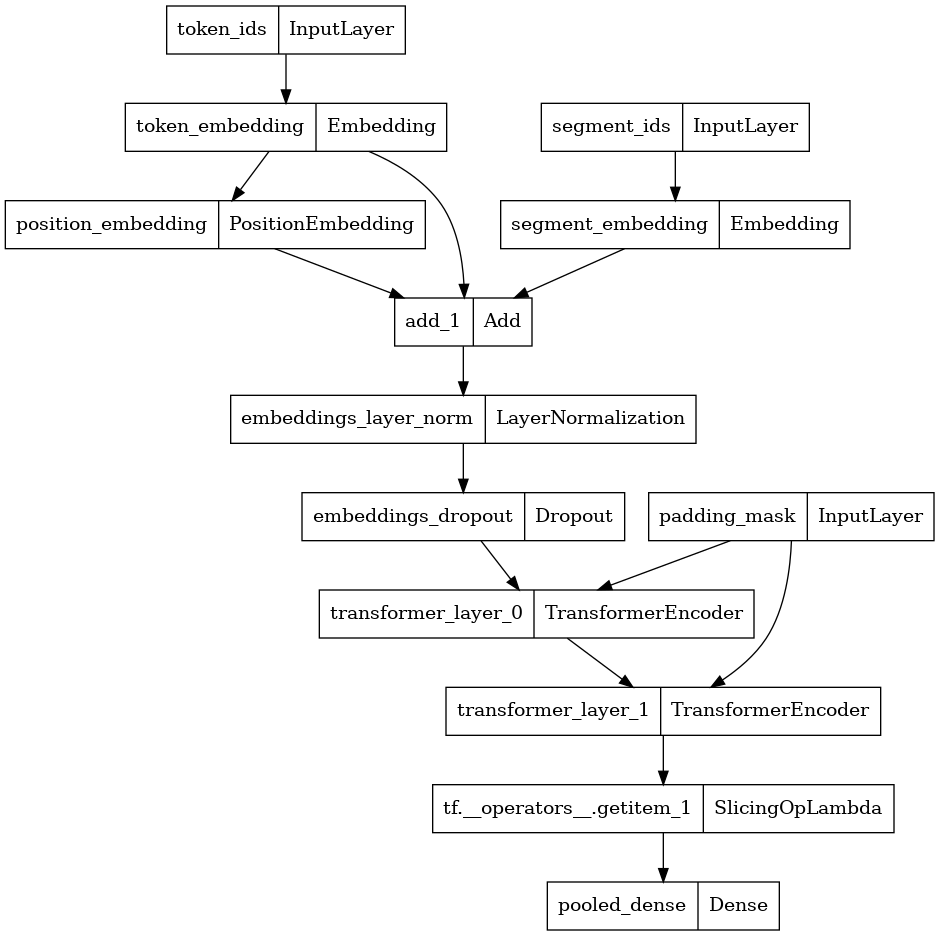

In [33]:
tf.keras.utils.plot_model(classifier.layers[3])

In [34]:
embedding_model = tf.keras.Model(
    inputs=classifier.input, outputs=classifier.layers[3].layers[6].output
)

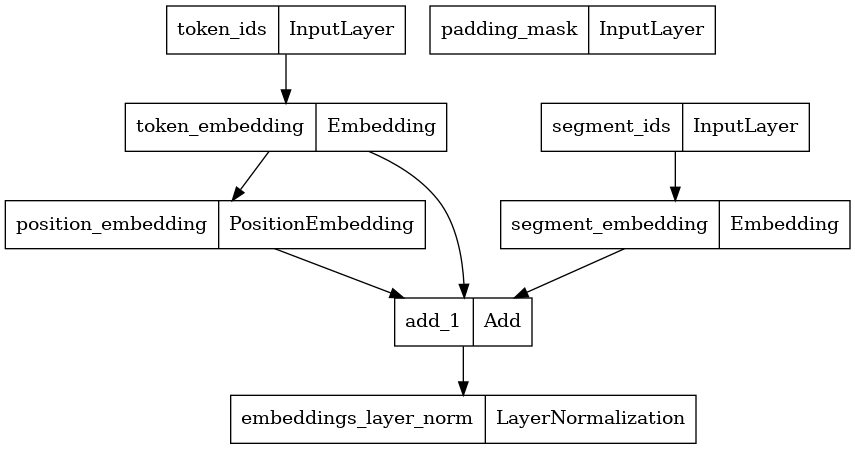

In [35]:
tf.keras.utils.plot_model(embedding_model)

In [223]:
classifier.layers[3].summary()

Model: "bert_backbone_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 token_embedding (Embedding  (None, None, 128)            3906816   ['token_ids[0][0]']           
 )                                                                                                
                                                                                                  
 segment_ids (InputLayer)    [(None, None)]               0         []                            
                                                                                                  
 position_embedding (Positi  (None, None, 128)            65536     ['token_embeddin

In [229]:
bert_backbone = tf.keras.Model(
    inputs=[
        classifier.layers[3].layers[7].input,
        classifier.layers[3].layers[8].input,
    ],
    outputs=classifier.layers[3].layers[-1].output,
)

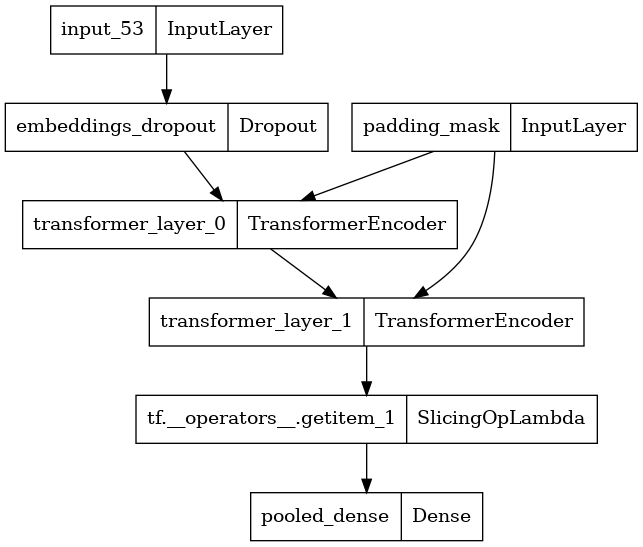

In [230]:
tf.keras.utils.plot_model(bert_backbone)

In [231]:
cls_head = tf.keras.Model(
    inputs=classifier.layers[-2].input, outputs=classifier.layers[-1].output
)

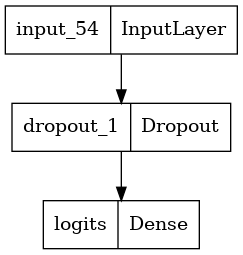

In [232]:
tf.keras.utils.plot_model(cls_head)

In [245]:
tokens = classifier._preprocessor(tf.constant(texts[:1]))
embedding = embedding_model(tokens)
bert_output = bert_backbone([embedding, tokens["padding_mask"]])
logits = cls_head(bert_output)
logits

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.05474576, 0.09981707]], dtype=float32)>

In [246]:
tokens = classifier._preprocessor(tf.constant(texts[:1]))
embeddings = embedding_model(tokens)
with tf.GradientTape() as tape:
    tape.watch(embeddings)
    bert_output = bert_backbone([embeddings, tokens["padding_mask"]])
    logits = cls_head(bert_output)

    indices = tf.argmax(logits, axis=-1)
    pred = tf.gather_nd(logits, [[i, idx] for i, idx in enumerate(indices)])

input_emb_grads = tape.gradient(pred, embeddings)
input_emb_grads

<tf.Tensor: shape=(1, 512, 128), dtype=float32, numpy=
array([[[ 2.5211675e-03, -3.2409839e-02, -6.9019878e-03, ...,
          2.7296547e-02,  4.5807930e-03,  1.4555874e-02],
        [-9.9885708e-04, -2.8899801e-03,  4.8571019e-03, ...,
          1.7197364e-03,  6.7635463e-03,  2.8126221e-03],
        [-1.0863496e-03, -1.4005759e-03, -4.5379478e-05, ...,
         -5.9404876e-05,  2.2665113e-03,  1.7321140e-03],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]], dtype=float32)>

In [193]:
START_OFFSET = 1
END_OFFSET = 1


class LITBertModel(lit_model.Model):

    def __init__(self, model):
        # Load the model into memory so we're ready for interactive use.
        self._model = model
        self._embedding_model = tf.keras.Model(
            inputs=model.input, outputs=model.layers[3].layers[6].output
        )
        self._bert_backbone = tf.keras.Model(
            inputs=[
                model.layers[3].layers[7].input,
                model.layers[3].layers[8].input,
            ],
            outputs=model.layers[3].layers[-1].output,
        )
        self._cls_head = tf.keras.Model(
            inputs=classifier.layers[-2].input,
            outputs=classifier.layers[-1].output,
        )

    def _detokenize(self, indices):
        return [
            self._model.preprocessor.tokenizer.vocabulary[idx]
            for idx in indices
        ]

    # LIT API implementations

    def predict(self, inputs):
        """Predict on a stream of examples."""
        examples = [d["text"] for d in inputs]
        tokenized = self._model.preprocessor(examples)
        seq_lens = tf.reduce_sum(
            tf.cast(tokenized["padding_mask"], tf.int32), axis=-1
        )
        embeddings = self._embedding_model(tokenized)
        with tf.GradientTape() as tape:
            tape.watch(embeddings)
            bert_output = self._bert_backbone(
                [embeddings, tokenized["padding_mask"]]
            )
            logits = self._cls_head(bert_output)

            if "label" in inputs[0].keys():
                indices = [
                    1 if inp["label"] == "positive" else 0 for inp in inputs
                ]
            else:
                indices = tf.argmax(logits, axis=-1)

            pred = tf.gather_nd(
                logits, [[i, idx] for i, idx in enumerate(indices)]
            )

        probs = tf.keras.activations.softmax(logits)

        input_emb_grads = tape.gradient(pred, embeddings)

        return [
            {
                "prob": [prob.numpy()[1], prob.numpy()[0]],
                "tokens": self._detokenize(
                    tokens[START_OFFSET : slen - END_OFFSET]
                ),
                "input_embedding": emb[
                    START_OFFSET : slen - END_OFFSET
                ].numpy(),
                "input_emb_grad": grad[
                    START_OFFSET : slen - END_OFFSET
                ].numpy(),
            }
            for prob, tokens, emb, grad, slen in zip(
                probs,
                tokenized["token_ids"],
                embeddings,
                input_emb_grads,
                seq_lens,
            )
        ]

    def input_spec(self):
        """Describe the inputs to the model."""
        return {
            "text": lit_types.TextSegment(),
            "label": lit_types.CategoryLabel(
                required=False, vocab=["positive", "negative"]
            ),
        }

    def output_spec(self):
        """Describe the model outputs."""
        return {
            # The 'parent' keyword tells LIT where to look for gold labels when computing metrics.
            "prob": lit_types.MulticlassPreds(
                vocab=["positive", "negative"], parent="label"
            ),
            "tokens": lit_types.Tokens(parent="text"),
            "input_embedding": lit_types.TokenEmbeddings(align="tokens"),
            "input_emb_grad": lit_types.TokenGradients(
                align="tokens", grad_for="input_embedding"
            ),
        }

In [194]:
# Create the LIT widget with the model and dataset to analyze.
datasets = {"acllmdb": LITSentimentData(test_ds)}
models = {"BERT classifier": LITBertModel(classifier)}

widget.stop()
widget = notebook.LitWidget(models, datasets, port=8890)

::1 - - [05/Sep/2024 13:53:29] "POST /get_info HTTP/1.1" 200 24667
::1 - - [05/Sep/2024 13:53:29] "POST /get_dataset?dataset_name=acllmdb HTTP/1.1" 200 154508
::1 - - [05/Sep/2024 13:53:30] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
::1 - - [05/Sep/2024 13:53:37] "POST /get_metrics?model=BERT%20classifier&dataset_name=acllmdb&metrics=multiclass,paired&do_predict=1 HTTP/1.1" 200 162
::1 - - [05/Sep/2024 13:53:37] "POST /get_interpretations?model=BERT%20classifier&dataset_name=acllmdb&interpreter=classification&do_predict=1 HTTP/1.1" 200 17520
::1 - - [05/Sep/2024 13:53:49] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4


In [195]:
widget.render(height=600)

## Integrated Gradients

In [218]:
START_OFFSET = 1
END_OFFSET = 1


class LITBertModel(lit_model.Model):

    def __init__(self, model):
        # Load the model into memory so we're ready for interactive use.
        self._model = model
        self._embedding_model = tf.keras.Model(
            inputs=model.input, outputs=model.layers[3].layers[6].output
        )
        self._bert_backbone = tf.keras.Model(
            inputs=[
                model.layers[3].layers[7].input,
                model.layers[3].layers[8].input,
            ],
            outputs=model.layers[3].layers[-1].output,
        )
        self._cls_head = tf.keras.Model(
            inputs=classifier.layers[-2].input,
            outputs=classifier.layers[-1].output,
        )

    def _detokenize(self, indices):
        return [
            self._model.preprocessor.tokenizer.vocabulary[idx]
            for idx in indices
        ]

    # LIT API implementations

    def predict(self, inputs):
        """Predict on a stream of examples."""
        examples = [d["text"] for d in inputs]
        tokenized = self._model.preprocessor(examples)
        seq_lens = tf.reduce_sum(
            tf.cast(tokenized["padding_mask"], tf.int32), axis=-1
        )
        embeddings = self._embedding_model(tokenized)
        if "input_embedding" in inputs[0].keys():
            pertubations = tf.convert_to_tensor(
                [inp["input_embedding"] for inp in inputs]
            )
            step_size, ptb_len, emd_dim = pertubations.shape
            pertubations = tf.reshape(
                pertubations, (step_size * ptb_len, emd_dim)
            )
            update_indices = [
                [s, l + START_OFFSET]
                for s in range(step_size)
                for l in range(ptb_len)
            ]
            embeddings = tf.tensor_scatter_nd_update(
                embeddings, update_indices, pertubations
            )
        with tf.GradientTape() as tape:
            tape.watch(embeddings)
            bert_output = self._bert_backbone(
                [embeddings, tokenized["padding_mask"]]
            )
            logits = self._cls_head(bert_output)
            if "label" in inputs[0].keys():
                indices = [
                    1 if inp["label"] == "positive" else 0 for inp in inputs
                ]
            else:
                indices = tf.argmax(logits, axis=-1)
            pred = tf.gather_nd(
                logits, [[i, idx] for i, idx in enumerate(indices)]
            )

        probs = tf.keras.activations.softmax(logits)

        input_emb_grads = tape.gradient(pred, embeddings)

        return [
            {
                "prob": [prob.numpy()[1], prob.numpy()[0]],
                "tokens": self._detokenize(
                    tokens[START_OFFSET : slen - END_OFFSET]
                ),
                "input_embedding": emb[
                    START_OFFSET : slen - END_OFFSET
                ].numpy(),
                "input_emb_grad": grad[
                    START_OFFSET : slen - END_OFFSET
                ].numpy(),
            }
            for prob, tokens, emb, grad, slen in zip(
                probs,
                tokenized["token_ids"],
                embeddings,
                input_emb_grads,
                seq_lens,
            )
        ]

    def input_spec(self):
        """Describe the inputs to the model."""
        return {
            "text": lit_types.TextSegment(),
            "label": lit_types.CategoryLabel(
                required=False, vocab=["positive", "negative"]
            ),
            "input_embedding": lit_types.TokenEmbeddings(
                required=False, align="tokens"
            ),
        }

    def output_spec(self):
        """Describe the model outputs."""
        return {
            # The 'parent' keyword tells LIT where to look for gold labels when computing metrics.
            "prob": lit_types.MulticlassPreds(
                vocab=["positive", "negative"], parent="label"
            ),
            "tokens": lit_types.Tokens(parent="text"),
            "input_embedding": lit_types.TokenEmbeddings(align="tokens"),
            "input_emb_grad": lit_types.TokenGradients(
                align="tokens",
                grad_for="input_embedding",
                grad_target_field_key="label",
            ),
        }

In [219]:
# Create the LIT widget with the model and dataset to analyze.
datasets = {"acllmdb": LITSentimentData(test_ds)}
models = {"BERT classifier": LITBertModel(classifier)}

widget.stop()
widget = notebook.LitWidget(models, datasets, port=8890)

::1 - - [05/Sep/2024 14:14:38] "POST /get_info HTTP/1.1" 200 24845
::1 - - [05/Sep/2024 14:14:38] "POST /get_dataset?dataset_name=acllmdb HTTP/1.1" 200 154508
::1 - - [05/Sep/2024 14:14:45] "POST /get_metrics?model=BERT%20classifier&dataset_name=acllmdb&metrics=multiclass,paired&do_predict=1 HTTP/1.1" 200 162
::1 - - [05/Sep/2024 14:14:45] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
::1 - - [05/Sep/2024 14:14:45] "POST /get_interpretations?model=BERT%20classifier&dataset_name=acllmdb&interpreter=classification&do_predict=1 HTTP/1.1" 200 17520


In [220]:
widget.render(height=600)

In [217]:
from lit_nlp.components import gradient_maps

ig = gradient_maps.IntegratedGradients()

ig_results = ig.run(
    LITSentimentData(test_ds).examples[:1],
    LITBertModel(classifier),
    LITSentimentData(test_ds),
)
ig_results

[{'input_emb_grad': TokenSalience(tokens=['i', 'think', 'dirty', 'dancing', 'was', 'a', 'great', 'movie', ',', 'they', 'tried', 'to', 'make', 'another', 'one', 'havana', 'nights', 'which', 'was', 'good', 'but', 'it', 'was', 'nothing', 'like', 'dirty', 'dancing', '.', 'i', 'would', 'like', 'to', 'see', 'another', 'dirty', 'dancing', 'with', 'the', 'same', 'people', '.', 'without', 'them', 'i', 'think', 'it', 'would', 'be', 'a', 'mess', '.', 'a', 'lot', 'of', 'times', 'movies', 'are', 'made', 'then', 'when', 'they', 'try', 'to', 'add', 'on', 'more', 'they', 'start', 'to', 'change', 'the', 'people', 'an', 'make', 'the', 'movies', 'go', 'down', 'hill', '.', 'i', 'would', 'love', 'to', 'see', 'dirty', 'dancing', 'have', 'another', 'one', 'to', 'see', 'what', 'happened', 'after', 'they', 'were', 'able', 'to', 'be', 'together', '.', 'patrick', 'an', 'jennifer', 'did', 'so', 'well', 'together', '.', 'this', 'movie', 'was', 'made', 'in', '1997', 'its', 'time', 'to', 'make', 'another', 'one', '.

In [330]:
df = pd.DataFrame(
    [
        ig_results[0]["input_emb_grad"].tokens,
        ig_results[0]["input_emb_grad"].salience,
    ],
    index=["token", "salience"],
)

salience_series = ig_results[0]["input_emb_grad"].salience
abs_max = max(abs(salience_series.max()), abs(salience_series.min()))
df.style.background_gradient(
    axis=1,
    gmap=df.loc["salience", :].apply(pd.to_numeric),
    vmin=-abs_max,
    vmax=abs_max,
    cmap="seismic",
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138
token,i,think,dirty,dancing,was,a,great,movie,",",they,tried,to,make,another,one,havana,nights,which,was,good,but,it,was,nothing,like,dirty,dancing,.,i,would,like,to,see,another,dirty,dancing,with,the,same,people,.,without,them,i,think,it,would,be,a,mess,.,a,lot,of,times,movies,are,made,then,when,they,try,to,add,on,more,they,start,to,change,the,people,an,make,the,movies,go,down,hill,.,i,would,love,to,see,dirty,dancing,have,another,one,to,see,what,happened,after,they,were,able,to,be,together,.,patrick,an,jennifer,did,so,well,together,.,this,movie,was,made,in,1997,its,time,to,make,another,one,.,but,this,time,start,where,it,left,off,an,keep,the,same,people,in,it,.
salience,0.014261,-0.002992,-0.004922,0.004781,-0.005915,0.006495,0.030867,-0.003785,0.006632,0.007742,-0.039481,0.004610,-0.004976,-0.003500,0.001578,0.016113,0.002132,0.000228,-0.005390,0.011774,0.002035,0.012808,-0.005836,-0.027479,0.001626,-0.002677,0.007186,0.001948,0.010695,-0.011365,-0.003171,0.005458,0.012721,-0.001787,-0.008362,0.002474,0.009434,0.006574,-0.019470,-0.001208,0.002534,0.005287,0.003309,0.009682,-0.003376,0.014403,-0.007815,0.002027,0.004974,-0.088144,0.000333,0.002337,0.002136,0.003715,0.004052,0.006119,0.001460,-0.004209,-0.003757,-0.002320,0.007668,-0.007009,0.004578,-0.003606,0.007327,0.003783,0.009104,-0.010196,0.005207,-0.005893,0.006843,-0.000258,0.004638,-0.007329,0.005731,0.008050,0.003881,-0.008273,0.002511,0.000535,0.012032,-0.014477,0.019099,0.004208,0.013227,-0.005983,0.004206,-0.002678,-0.004822,0.002676,0.004588,0.012174,0.009509,-0.001103,0.001795,0.007059,-0.018109,0.009168,0.003942,0.000978,0.007944,0.000048,0.004205,0.005074,-0.002416,-0.002398,-0.006378,0.015768,0.007374,0.000037,0.000148,-0.007075,-0.007051,-0.006161,0.006151,0.006127,0.006926,0.002147,0.003812,-0.006555,-0.004629,0.002481,-0.000619,0.001660,0.001191,0.003227,-0.004275,-0.001467,0.015433,-0.034444,-0.007499,0.003535,0.008670,0.004167,-0.015571,0.001243,0.005982,0.011249,0.000131
